In [21]:
# tutorial from: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

import re
import numpy as np 
import pandas as pd 
from pprint import pprint
from tqdm import tqdm 

import gensim 
import gensim.corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from nltk.corpus import stopwords

import spacy

import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from pathlib import Path

In [22]:
import pymongo

conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)
collection_to_search = client.visualizing_sep.sep_entries

sep_entries = list(collection_to_search.find( filter={},
                                     projection={'main_text':1, 'preamble_text':1, 'title':1},
                                     sort=[('title',1)]))

sep_df = pd.DataFrame(sep_entries)
sep_df.head()


,_id,title,preamble_text,main_text
0,5f1bb235896f82cdbda61077,17th and 18th Century Theories of Emotions,Early modern philosophy in Europe and Great Br...,1. Introduction 1.1 Difficulties of Approach: ...
1,5f1baf2c896f82cdbda60ed2,18th Century British Aesthetics,18th-century British aesthetics addressed itse...,1. Internal-Sense Theories 1.1 Shaftesbury Sh...
2,5f1baf2d896f82cdbda60ed3,18th Century French Aesthetics,French philosophers of the Ancien Régime wrote...,1. The Classical Legacy French thinkers consi...
3,5f1baf2f896f82cdbda60ed4,18th Century German Aesthetics,The philosophical discipline of aesthetics did...,1. Leibniz and Wolff: Perfection and Truth T...
4,5f1baf09896f82cdbda60ebf,18th Century German Philosophy Prior to Kant,"In Germany, the eighteenth century was the age...",1. Christian Thomasius (1655–1728) Although ...


In [23]:
stop_words = stopwords.words('english')
stop_words.extend (['from', 'subject','re','edu','use'])

In [24]:
# 7. Remove emails and newline characters

sep_data = sep_df.preamble_text.values.tolist()

sep_data = [sep_article.strip() for sep_article in sep_data]
sep_data = [re.sub('\s+',' ', sep_article) for sep_article in sep_data]
sep_data = [re.sub('\'','',sep_article) for sep_article in sep_data]

pprint(sep_data[2:3])

['French philosophers of the Ancien Régime wrote treatises on beauty or taste; '
 'the term “aesthetics”, coined in Latin as “aesthetica” by German philosopher '
 'Alexander Baumgarten in 1735 (§116), was not in popular usage in France and '
 'appeared only in rare instances at the end of the eighteenth century. '
 'Philosophers described taste (“goût” or “goust”) as a sentiment that allowed '
 'both creators and consumers to discern the beauty of an object. At times, '
 'authors focused more on the object, such as a painting; at other times, they '
 'examined what was happening inside the mind of the person who created it or '
 'of the person who looked at it. Eighteenth-century theories of beauty were '
 'in many ways a continuation of debates that took place during the previous '
 'century. The changes that were introduced during the Enlightenment included '
 'an increased focus on the mind’s inner workings when perceiving beauty and '
 'attempts at finding universal standards that 

In [25]:
# 8. Tokenize words and Clean-up text

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# data_words = list(sent_to_words(data))
sep_data_words = list(sent_to_words(sep_data))

# pprint(data_words[:2])
pprint(sep_data_words[:2])

[['early',
  'modern',
  'philosophy',
  'in',
  'europe',
  'and',
  'great',
  'britain',
  'is',
  'awash',
  'with',
  'discussions',
  'of',
  'the',
  'emotions',
  'they',
  'figure',
  'not',
  'only',
  'in',
  'philosophical',
  'psychology',
  'and',
  'related',
  'fields',
  'but',
  'also',
  'in',
  'theories',
  'of',
  'epistemic',
  'method',
  'metaphysics',
  'ethics',
  'political',
  'theory',
  'and',
  'practical',
  'reasoning',
  'in',
  'general',
  'moreover',
  'interest',
  'in',
  'the',
  'emotions',
  'links',
  'philosophy',
  'with',
  'work',
  'in',
  'other',
  'sometimes',
  'unexpected',
  'areas',
  'such',
  'as',
  'medicine',
  'art',
  'literature',
  'and',
  'practical',
  'guides',
  'on',
  'everything',
  'from',
  'child',
  'rearing',
  'to',
  'the',
  'treatment',
  'of',
  'subordinates',
  'because',
  'of',
  'the',
  'breadth',
  'of',
  'the',
  'topic',
  'this',
  'article',
  'can',
  'offer',
  'only',
  'an',
  'overview',

In [26]:
# 9. Creating Bigram and Trigram Models
bigram = gensim.models.Phrases(sep_data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[sep_data_words], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[sep_data_words[0]]])

['early', 'modern', 'philosophy', 'in', 'europe', 'and', 'great', 'britain', 'is', 'awash', 'with', 'discussions', 'of', 'the', 'emotions', 'they', 'figure', 'not', 'only', 'in', 'philosophical', 'psychology', 'and', 'related', 'fields', 'but', 'also', 'in', 'theories', 'of', 'epistemic', 'method', 'metaphysics', 'ethics', 'political', 'theory', 'and', 'practical', 'reasoning', 'in', 'general', 'moreover', 'interest', 'in', 'the', 'emotions', 'links', 'philosophy', 'with', 'work', 'in', 'other', 'sometimes', 'unexpected', 'areas', 'such', 'as', 'medicine', 'art', 'literature', 'and', 'practical', 'guides', 'on', 'everything', 'from', 'child', 'rearing', 'to', 'the', 'treatment', 'of', 'subordinates', 'because', 'of', 'the', 'breadth', 'of', 'the', 'topic', 'this', 'article', 'can', 'offer', 'only', 'an', 'overview', 'but', 'perhaps', 'it', 'will', 'be', 'enough', 'to', 'give', 'some', 'idea', 'how', 'philosophically', 'rich', 'and', 'challenging', 'the', 'conception', 'of', 'the', 'emo

In [27]:
# 10. Remove Stopwords, Make Bigrams and Lemmatize

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_posttags=['NOUN', 'ADJ','VERB','ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_posttags])
    
    return texts_out 

sep_data_words_nostops = remove_stopwords(sep_data_words)
sep_data_words_bigrams = make_bigrams(sep_data_words_nostops)

nlp = spacy.load('en_core_web_sm', disable =['parser','ner'])

sep_data_lemmatized = lemmatization(sep_data_words_bigrams, allowed_posttags=['NOUN', 'ADJ', 'VERB', 'ADV'])

pprint(len(sep_data_lemmatized))


1692


In [28]:
# 11. Create the Dictionary and Corpus needed for Topic Modeling

id2word = gensim.corpora.Dictionary(sep_data_lemmatized)
texts = sep_data_lemmatized

corpus = [id2word.doc2bow(text) for text in texts]


In [40]:
# 12. Building the Topic Model
num_topics = 14
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [41]:
# 13. View the topics in LDA model

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.014*"question" + 0.014*"may" + 0.010*"view" + 0.010*"way" + 0.008*"claim" '
  '+ 0.008*"sense" + 0.008*"knowledge" + 0.008*"thing" + 0.008*"term" + '
  '0.008*"would"'),
 (1,
  '0.067*"consciousness" + 0.046*"realism" + 0.042*"skepticism" + '
  '0.041*"realist" + 0.039*"socrate" + 0.029*"capture" + 0.024*"conscious" + '
  '0.023*"skeptical" + 0.022*"promise" + 0.021*"thereby"'),
 (2,
  '0.067*"belief" + 0.049*"evidence" + 0.043*"justification" + '
  '0.037*"pluralism" + 0.026*"decision" + 0.016*"pluralist" + 0.016*"option" + '
  '0.016*"consistent" + 0.015*"justified" + 0.015*"construction"'),
 (3,
  '0.018*"advantage" + 0.014*"perplex" + 0.012*"preference" + 0.007*"philo" + '
  '0.006*"excellence" + 0.003*"executive" + 0.000*"sound" + '
  '0.000*"manipulation" + 0.000*"tonya" + 0.000*"tactic"'),
 (4,
  '0.036*"philosophy" + 0.028*"work" + 0.025*"philosophical" + '
  '0.017*"philosopher" + 0.013*"tradition" + 0.012*"early" + 0.010*"think" + '
  '0.010*"also" + 0.009*"write" +

In [31]:
# 14. Compute Model Perplexity and Coherence Score

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=sep_data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.858747745921848

Coherence Score:  0.43609174669389117


In [32]:
# 15. Visualize the topics-keywords
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model,corpus,id2word)

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.323502 -0.005533       1        1  18.471100
11     0.296542  0.197584       2        1  13.654159
30     0.276188  0.219137       3        1  12.225786
21     0.293456 -0.080610       4        1   9.763106
13     0.248070 -0.014197       5        1   8.100325
27     0.192679 -0.003556       6        1   5.902141
2      0.204423 -0.061398       7        1   5.053326
19     0.121727 -0.210437       8        1   3.913381
0      0.183258 -0.120877       9        1   3.752126
24     0.135505 -0.174324      10        1   2.995680
4      0.104794  0.262447      11        1   2.917129
18     0.003784 -0.070027      12        1   1.485803
31    -0.014392 -0.097282      13        1   1.332442
15    -0.041848 -0.000103      14        1   1.290156
5     -0.045402  0.002237      15        1   1.121733
26    -0.046569 -0.002569      16        1   0.992516
25    -0.072333 -0.023180      17        1   0.990573
29    -0.087432 -0.037362      18        1   0.911784
20    -0.043538  0.003491      19        1   0.834117
17    -0.100101  0.000456      20        1   0.816718
28    -0.104091 -0.037225      21        1   0.642489
14    -0.140721  0.018793      22        1   0.521033
12    -0.128309  0.019257      23        1   0.480742
22    -0.147318  0.014226      24        1   0.404620
10    -0.146163  0.025407      25        1   0.293625
16    -0.170838  0.025687      26        1   0.253511
8     -0.177065  0.025494      27        1   0.220322
9     -0.177500  0.014475      28        1   0.196673
1     -0.173157  0.024799      29        1   0.175689
3     -0.179552  0.028026      30        1   0.143178
23    -0.191161  0.028073      31        1   0.099414
6     -0.196437  0.029090      32        1   0.044602, topic_info=     Category        Freq         Term        Total  loglift  logprob
89    Default  2633.00000       theory  2633.000000  30.0000  30.0000
66    Default  2799.00000   philosophy  2799.000000  29.0000  29.0000
566   Default   761.00000      section   761.000000  28.0000  28.0000
395   Default  1121.00000        moral  1121.000000  27.0000  27.0000
431   Default   805.00000        truth   805.000000  26.0000  26.0000
...       ...         ...          ...          ...      ...      ...
4299  Topic32     0.00673      regular     0.930959   2.7855  -9.6461
4302  Topic32     0.00673      trouble     0.930959   2.7855  -9.6461
4301  Topic32     0.00673        suppe     0.930959   2.7855  -9.6461
4277  Topic32     0.00673  approvingly     0.930959   2.7855  -9.6461
4323  Topic32     0.00673         hart     0.930959   2.7855  -9.6461

[1536 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
792       8  0.356773   ability
792      12  0.619658   ability
1453     14  0.981031   absence
984      26  0.969356  absolute
1789     28  0.940571    absurd
...     ...       ...       ...
334      11  0.352225     write
865       2  0.035407   writing
865       3  0.680319   writing
865      11  0.280726   writing
438       3  0.994669      year

[1921 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 12, 31, 22, 14, 28, 3, 20, 1, 25, 5, 19, 32, 16, 6, 27, 26, 30, 21, 18, 29, 15, 13, 23, 11, 17, 9, 10, 2, 4, 24, 7])

In [29]:
# # 16. Building LDA Mallet Model


# # mallet_path =  path_to_files = Path.cwd() / 'mallet-2.0.8/bin/mallet'
# mallet_path = r"C:\mallet\bin\mallet"
# mallet_path = str(mallet_path)
# print(mallet_path)

# lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path, 
#                                             corpus=corpus, 
#                                             num_topics=22, 
#                                             id2word=id2word)

# # #showtopics 

# pprint(lda_mallet.show_topics(formatted=False))

# coherence_model_ldamallet = CoherenceModel(model=lda_mallet, texts=sep_data_lemmatized, dictionary=id2word, coherence='c_v')
# coherence_ldamallet = coherence_model_ldamallet.get_coherence()
# print('\nCoherence Score: ', coherence_ldamallet)

C:\mallet\bin\mallet
[(14,
  [('language', 0.030968372648768037),
   ('meaning', 0.016564983616054456),
   ('word', 0.014975469341202455),
   ('semantic', 0.014435975885728768),
   ('sentence', 0.012828357803646107),
   ('expression', 0.011199015152886653),
   ('linguistic', 0.010960044897441932),
   ('term', 0.009725365244310879),
   ('speaker', 0.008508789398410486),
   ('context', 0.007592736752539059)]),
 (12,
  [('form', 0.014601302557292223),
   ('thing', 0.01295332331013318),
   ('soul', 0.010293849493736646),
   ('human', 0.008370633629098016),
   ('intellect', 0.008349990882787046),
   ('matter', 0.008291503101572633),
   ('term', 0.007919933667975188),
   ('aristotle', 0.007789196274672382),
   ('work', 0.007544923776659247),
   ('substance', 0.007317853567238585)]),
 (4,
  [('art', 0.03833651378561558),
   ('aesthetic', 0.029170230966638153),
   ('work', 0.023623083503323025),
   ('beauty', 0.01404224517996973),
   ('object', 0.013680331644403501),
   ('experience', 0.012430

In [33]:
# 17. How to find the optimal number of topics for LDA?


def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step), desc='Processing'):
        # model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [37]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=sep_data_lemmatized, start=8, limit=30, step=2)

Processing: 100%|██████████| 11/11 [07:25<00:00, 40.51s/it]


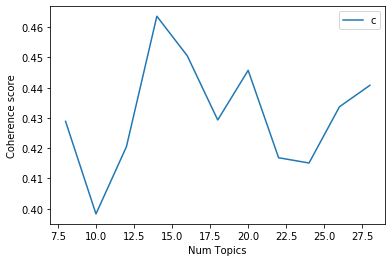

In [38]:
# Show graph
limit=30; start=8; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [39]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

    #32 topics

Num Topics = 8  has Coherence Value of 0.4289
Num Topics = 10  has Coherence Value of 0.3983
Num Topics = 12  has Coherence Value of 0.4205
Num Topics = 14  has Coherence Value of 0.4636
Num Topics = 16  has Coherence Value of 0.4505
Num Topics = 18  has Coherence Value of 0.4293
Num Topics = 20  has Coherence Value of 0.4457
Num Topics = 22  has Coherence Value of 0.4169
Num Topics = 24  has Coherence Value of 0.4151
Num Topics = 26  has Coherence Value of 0.4337
Num Topics = 28  has Coherence Value of 0.4408
